# ADP algorihtm 
- The goal of this file is to first learn how does the ADP work on a simple example and then use it to solve the problem of gas power plant valuation. 

- First, I will setup a simple example of three states and two actions. Each of the two actions changes the probability distributions of results and "costs" some reward. 
    - I will compute the optimal strategy for this example with real dynamic programming and then with the approximative dynamic programming. 
    - I will make heuristic strategies as well. 

## Three states two actions

In [1]:
import sys
import os
sys.path.append("/Users/filiprolenec/Desktop/MT/MTpython/src")

In [2]:
import simple_example.strategy as s
from simple_example.simulation import run_simulation
import matplotlib.pyplot as plt 
import numpy as np
from simple_example.setup import ProblemSetup
from sklearn.linear_model import LinearRegression
from simple_example.state import get_new_state


# Classical Dynamic programming 

In [3]:
from simple_example.dp_algorithm import classic_dp

In [4]:
horizon_vf = [0,0,0]
problem_setup = ProblemSetup()
prob_matrix = problem_setup.prob_matrix
reward_matrix = problem_setup.reward_matrix
time_epochs = problem_setup.time_epochs

In [5]:
classic_dp(horizon_vf, problem_setup)

({9: {1: 2, 2: 1, 3: 2},
  8: {1: 2, 2: 1, 3: 2},
  7: {1: 2, 2: 1, 3: 2},
  6: {1: 2, 2: 1, 3: 2},
  5: {1: 2, 2: 1, 3: 2},
  4: {1: 2, 2: 1, 3: 2},
  3: {1: 2, 2: 1, 3: 2},
  2: {1: 2, 2: 1, 3: 2},
  1: {1: 2, 2: 1, 3: 2},
  0: {1: 2, 2: 1, 3: 2}},
 {9: [6.3999999999999995, 13.8, 14.399999999999999],
  8: [19.88, 26.48, 26.16],
  7: [31.995999999999995, 38.768, 38.804],
  6: [44.516, 51.2352, 51.1472],
  5: [56.90168, 63.63856, 63.593039999999995],
  4: [69.333008, 76.063872, 76.00384],
  3: [81.7487632, 88.48168, 88.4266032],
  2: [94.16983456, 100.90205055999999, 100.84528191999999],
  1: [106.58909091199999, 113.321546176, 113.26535516799999],
  0: [119.00896694399998, 125.7413405184, 125.6849522944]})

# Strategy result comparison

In [6]:
strategies = [s.heuristic_strategy_0, 
              s.heuristic_strategy_1, 
              s.heuristic_strategy_2, 
              s.optimal_strategy]

In [7]:
all_results = {}
initial_state = 0

for strategy in strategies: 
    strategy_results = {}
    for i in range(10000): 
        strategy_results[i] = run_simulation(strategy, initial_state, problem_setup)
            
    all_results[strategy.__name__] = strategy_results 

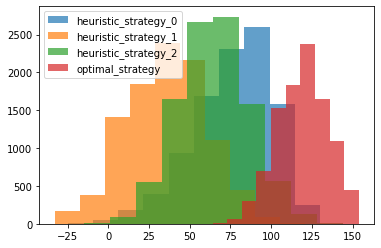

In [8]:
for strategy in strategies: 
    plt.hist(all_results[strategy.__name__].values(), label =strategy.__name__, alpha = 0.7)
plt.legend()

In [9]:
for strategy in strategies: 
    print(np.mean(list(all_results[strategy.__name__].values())))

76.5032
35.4256
64.5967
118.8758


# ADP algorithm finding the best strategy 
$$V_t(s, \theta) = \theta_0 + \theta_{t,1} \cdot \phi_1(s) + \theta_{t,2} \cdot \phi_2(s) + \theta_{t,3} \cdot \phi_3(s)$$

Where $\phi_i(s)$ functions are onli indicator functions of each state.

## ADP steps: 
1. Initialize parameters $\theta_t$
2. Define basis functions $\phi_i(s)$
3. Loop over time epochs from the last to the first: 
    1. Loop over fixed amount of sampled states: 
        1. Determine optimal decisions based on those states, in my case 1 action out of 6. 
        2. Simulate what happens after my action (s,a,s) triplet and reward (plus value function estimate in the following state) 
    2. Make a linear regression on the new findings. Get new $\theta_i$ based on rewards + future vf and values of the basis functions. 
    3. Update the parameters, either fully, or with a learning step. 
4. Check how far are the value functions from the truth (which I know here) 

### 1. initialize params

In [10]:
thetas = [[0 for i in range(3)] for i in time_epochs]

In [11]:
thetas[0]

[0, 0, 0]

In [12]:
theta_initial = [0,0,0,0]

### 2. Define basis functions

In [13]:
def bf_1(s): 
    return 1 if s == 0 else 0 

def bf_2(s): 
    return 1 if s == 1 else 0 

def bf_3(s): 
    return 1 if s == 2 else 0 
basis_functions = [bf_1,bf_2,bf_3]

### 3.a determine optimal decision based on a state and simulate what happens 

In [14]:
def vector_mult(a,b): 
    return sum([i*j for i,j in zip(a,b)])

In [15]:
state = 2
action = 1
actions = range(2)
states = range(3)
t = 9

In [16]:
prob_matrix[2][1]


[0.3, 0.4, 0.3]

In [17]:
problem_setup.reward_matrix[2][1]

[10, 18, 14]

In [18]:
vector_mult(prob_matrix[2][1], reward_matrix[2][1])

14.399999999999999

In [19]:
vf = []

In [20]:
from simple_example.vf import Vf

In [21]:
def create_vfs(time_epochs, theta_initial):
    vfs = []
    for i in time_epochs: 
        vfs.append(Vf(theta_initial))
    return

In [22]:
from simple_example.setup import ProblemSetup

In [23]:
def get_exp_value(state, action, prob_matrix, reward_matrix, future_vf): 
    rewards = reward_matrix[state][action]
    future_vf_values = future_vf.compute_all_values()
    total_rewards = [i+j for i,j in zip(rewards, future_vf_values)]
    return vector_mult(prob_matrix[state][action], total_rewards) 

In [24]:
def get_best_action(state, future_vf, prob_matrix, reward_matrix): 
    exp_rewards = []
    for action in actions: 
        exp_rewards.append(get_exp_value(state, action, prob_matrix, reward_matrix, future_vf))
    return np.argmax(exp_rewards)

### 3.b for x random states, determine the best action, perform the evolution, get the actual reward and note it. 

In [25]:
sample_size = 50

In [26]:
def get_state_reward_pairs(sample_size, states, future_vf, prob_matrix, reward_matrix): 
    state_reward_pairs = []
    for i in range(sample_size): 
        state = np.random.choice(states, p=[0.34, 0.33, 0.33])

        action = get_best_action(state, future_vf, prob_matrix, reward_matrix) 
        new_state = get_new_state(state, action, prob_matrix)

        reward = reward_matrix[state][action][new_state] + future_vf.compute_value(new_state)
        state_reward_pairs.append([state, reward])
    return state_reward_pairs 

### 3.c linear regression on the results 
- I have the following model: 
$$V_t(s, \theta) = \theta_0 + \theta_{t,1} \cdot \phi_1(s) + \theta_{t,2} \cdot \phi_2(s) + \theta_{t,3} \cdot \phi_3(s)$$
- and I want to predict the parameters \theta, based on the realizaitons V_t(s) and the variable s. 
- This model is simple, and we expect that each of the parameters will be close to the expected value. 
    - In reality, it will be such a number that minimizes the sum of squares of the errors. 
    - For example if there are three outcomes with 1/3 probability and rewards 1,3,100, the number will be closer to 50 than 33. 
    - Thus even for this model, the result will in uneven settings of reeward be only an approximation. 

### 3.c Intercept makes the model crazy 
- There are numbers like 10^14 
- Since there is no reason for the intercept, i will just make a model without it here. The model becomes: 

$$V_t(s, \theta) = \theta_{t,1} \cdot \phi_1(s) + \theta_{t,2} \cdot \phi_2(s) + \theta_{t,3} \cdot \phi_3(s)$$


preparing the regression variables

In [27]:
def prepare_regression_variables(state_reward_pairs, basis_functions): 
    x = []
    y = []
    for pair in state_reward_pairs: 
        x.append([basis_functions[0](pair[0]),
                  basis_functions[1](pair[0]),
                  basis_functions[2](pair[0])])
        y.append(pair[1])
        
    return x,y

actual values = 6.4, 13.8, 14.4

### But the actual prediction makes sense i guess 

In [28]:
def update_vf_coef(current_vf, next_vf, problem_setup, sample_size, basis_functions):
    state_reward_pairs_raw = get_state_reward_pairs(sample_size, 
                                                    problem_setup.states, 
                                                    next_vf,
                                                    problem_setup.prob_matrix,
                                                    problem_setup.reward_matrix)
    
    x,y = prepare_regression_variables(state_reward_pairs_raw, basis_functions)
    model = LinearRegression(fit_intercept=False).fit(x, y)
    current_vf.set_params(model.coef_)

106.58909091199999, 113.321546176, 113.26535516799999

Even with 5000 samples and 20 loops of update, there is still a 0.5% difference from the reality. This might be caused by a different optimization function as discussed above. Linear algorithm does not return the mean value, rather a value from which the sum of squares of residuals is the lowest. 

A reasonable approximation can be seen as low as for 50 samples and 10 loops. 

In [29]:
problem_setup = ProblemSetup()

In [30]:
from simple_example.adp_algorithm import adp_algorithm_final

In [31]:
vfs_1 = adp_algorithm_final(loops_of_update=20, sample_size=50, problem_setup = problem_setup)

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [32]:
vfs_1[0].params

array([104.17630451, 113.07600179, 110.85370641])

106.58909091199999, 113.321546176, 113.26535516799999

In [35]:
vfs_1 = adp_algorithm_final(loops_of_update=100, sample_size=2000, problem_setup = problem_setup)

100% (100 of 100) |######################| Elapsed Time: 0:02:43 Time:  0:02:43


In [36]:
vfs_1[0].params

array([106.69024172, 113.28469842, 113.22032903])

106.58909091199999, 113.321546176, 113.26535516799999

# Conclusion 
- I have implemented the ADP algorithm on the simple example. 
- We can see that the approximation is really good in this example. The implementation is working. 
- This investigation will help with the implementation of the actual problem in the next phase. 
    - The complexity will rise significantly, each of the steps will be somehow harder and the computational complexity will rise too. Nevertheless, the framework is ready to be used. 